# Control Predictivo basado en Modelo

#### Salim Vargas Hernández


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import quadprog as qp
from scipy.integrate import odeint
import time

from plot_MPC import *

from IPython.display import HTML
from matplotlib import rc
rc('text', usetex=True)

### Modelado del problema cuadrático

In [2]:
def ddr(xVec, t, entrada):
    v, w = entrada(t)
    x, y, theta = xVec
    
    dxdt = [v*np.cos(theta), v*np.sin(theta), w]
    
    return dxdt

In [3]:
def A(j, k):
    """
    A(k + j | k)
    """
    global u_r
    global x_r
    global T
    
    v = u_r[k+j,0]
    theta = x_r[k+j,2]
    
    A = np.eye(3)
    A[0,2] = -v * np.sin(theta) * T
    A[1,2] = v * np.cos(theta) * T
    
    return A

def B(j, k):
    """
    B(k + j | k)
    """
    global u_r
    global x_r
    global T
    
    theta = x_r[k+j,2]
    
    B = np.zeros((3,2))
    
    B[0,0] = np.cos(theta) * T
    B[1,0] = np.sin(theta) * T
    B[2,1] = T
    
    return B

In [4]:
def pi(j, l, k):
    
    prod = np.eye(3)
    
    for i in range(j, l+1):
        prod = A(i,k)@prod
    
    return prod

In [5]:
def A_bar(k):
    
    global N
    
    A_k = np.zeros((N*3, 3))
    for i in range(N):
        A_k[3*i:3*i + 3, :] = pi(0, i, k)
    
    return A_k

def B_bar(k):
    
    global N
    
    B_k = np.zeros((N*3, N*2))
    
    for i in range(N):
        #diagonal
        B_k[3*i:3*i + 3, 2*i:2*i + 2] = B(i, k)
        
        for j in range(i):
            B_k[3*i:3*i + 3, 2*j:2*j + 2] = pi(j+1, i, k) @ B(j, k)
    
    return B_k

In [6]:
def Q_bar(diagonal):
    
    global N
    
    Q = np.diag(N*diagonal)
    
    return Q

In [7]:
def W_bar(diagonal):
    
    global N
    
    W = np.diag(N*diagonal)
    
    return W

In [8]:
def H(k):
    
    global Q_bar
    global R_bar
    
    return 2 * ( B_bar(k).T @ Q_bar @ B_bar(k) + R_bar )

def f(k, errX):
    
    global Q_bar
    global R_bar
    
    x = errX.reshape((3,1))
    
    return np.ravel(2 * B_bar(k).T @ Q_bar @ A_bar(k) @ x)

#### Restricciones

In [9]:
def u_min(k):
    
    return np.array([[-0.4], [-0.4]])

def u_max(k):
    
    return np.array([[0.4], [0.4]])

def u_min_bar(k):
    
    global u_r
    global N
    
    uMin = np.zeros((2*N, 1))
    for i in range(N):
        uMin[2*i:2*i + 2] = u_min(k + i) - np.array(u_r[k + i, :]).reshape((2,1))
    
    return uMin

def u_max_bar(k):
    
    global u_r
    global N
    
    uMax = np.zeros((2*N, 1))
    for i in range(N):
        uMax[2*i:2*i + 2] = u_max(k + i) - np.array(u_r[k + i, :]).reshape((2,1))
    
    return uMax

In [10]:
def G(k):
    
    global N
    
    G_k = np.zeros((2*N*2, N*2))
    
    G_k[:N*2, :] = np.eye(N*2)
    G_k[N*2:, :] = -np.eye(N*2)
    
    return G_k

def h(k):
    
    global N
    
    h_k = np.zeros((2*N*2, 1))
    
    h_k[:N*2, :] = u_max_bar(k)
    h_k[N*2:, :] = -u_min_bar(k)
    
    return np.ravel(h_k)

### Dinámica deseada

In [11]:
def u(t):
    if t <= (40/3)*np.pi or t > (80/3)*np.pi:
        return [0.3, 0.15]
    else:
        return [0.3, -0.15]

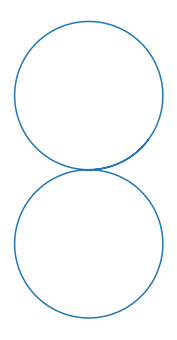

In [12]:
x0 = [0, 0, 0]

tIni = 0
tFin = 90
nt = 900

T = (tFin - tIni) / nt
tiempo = np.linspace(tIni, tFin, nt + 1)

sol = odeint(ddr, x0, tiempo, args=(u,))

u_r = np.zeros((nt + 1, 2))
for i, t in enumerate(tiempo):
    u_r[i] = u(t)

x_r = sol

fig, ax = plt.subplots(1, figsize=(6,6))
ax.plot(sol[:,0], sol[:,1])
ax.set_axis_off()
ax.set_aspect('equal');

In [13]:
def ruido_cte(proporcion, magnitud, dimension, k):
    return proporcion*magnitud*(np.random.random(dimension) - 0.5)

In [14]:
def perturbacion_cte(proporcion, magnitud, dimension, k):
    global tIni
    global T
    tiempo = tIni + T*k
    if tiempo > 13*np.pi:
        return proporcion*magnitud#*(np.random.random(dimension) - 0.5)
    else:
        return np.zeros(dimension)

In [15]:
def sin_perturbacion(proporcion, magnitud, dimension, k):
    return np.zeros(dimension)

### Control Predictivo Basado en Modelo

In [16]:
def MPC(x_0, x_r, u_r, N, nt, T, perturbacion, prop=0.0075, plot=True, plotStats=True, animation=True, **kwargs):
    x_k = x_0
    x_mpc = x_k.copy()
    u_mpc = np.zeros((nt-N+1, 2))
    phi_mpc = np.zeros(nt-N)
    x_pred = np.zeros((nt-N+1, N*3))

    for j in range(N):
        x_pred[0, 3*j: 3*j + 3] = x_k
    
    if plot:
        fig, ax = plt.subplots(1, figsize=(12,8))

    tiempoPromOpt = 0
    tiempoPromIter = 0

    for k in range(nt-N):

        tIniIter = time.time()
        errX = x_k - x_r[k,:]

        tIniOpt = time.time()
        sol = qp.solve_qp(H(k), -f(k, errX), -G(k).T, -h(k))
        tFinOpt = time.time()
        tiempoPromOpt = tFinOpt - tIniOpt
        
        solU = sol[0]
        errU = solU[:2]

        errX_pred = errX.copy()
        for j in range(N):
            x_k_pred = np.ravel( A(j,k)@errX_pred.reshape((3,1)) + B(j,k)@solU[2*j:2*j + 2].reshape((2,1)) ) + x_r[k+1+j,:]
            x_pred[k,3*j:3*j + 3] = x_k_pred
            errX_pred = x_k_pred - x_r[k+1+j,:]

        x_k = np.ravel( A(0,k)@errX.reshape((3,1)) + B(0,k)@errU.reshape((2,1)) ) + x_r[k+1,:]
        #ruido
        x_k = x_k + perturbacion(prop, np.linalg.norm(errU + u_r[k,:]), x_k.shape, k)
        
        if plot:
            ax.plot(x_k[0], x_k[1], 'og', alpha = 0.4)

        x_mpc = np.vstack((x_mpc,x_k))
        u_mpc[k, :] = errU + u_r[k,:]
        phi_mpc[k] = float( 0.5*solU.reshape((1,2*N))@H(k)@solU.reshape((2*N,1)) - f(k, errX).reshape((1,2*N))@solU.reshape((2*N,1)) )
        tFinIter = time.time()
        tiempoPromIter = tFinIter - tIniIter

    u_mpc[-1,:] = u_mpc[-2,:]

    print("Horizonte =", N)
    print("Tiempo promedio para problema de optimización =", tiempoPromOpt/(nt-N), "segundos")
    print("Tiempo promedio para iteración =", tiempoPromIter/(nt-N), "segundos")
    
    if plot:
        ax.plot(x_r[:nt-N+1, 0], x_r[:nt-N+1, 1], '--b', alpha = 0.7)
        ax.set_axis_off()
        ax.set_aspect('equal');
    
    if plotStats:
        plot_mpc(x_r, u_r, x_mpc, u_mpc, phi_mpc)
    
    if animation:
        anim = animacion_trayectoria(x_r, x_mpc, x_pred, N, nt, T, kwargs['animationFile']);
    else:
        anim = False
    
    return x_r, x_mpc, x_pred, u_mpc, phi_mpc, anim

In [17]:
diagQ = [1, 1, 0.5]
diagR = [0.1, 0.1]

x_0 = np.array([0, -1, np.pi/2])

### Simulaciones sin perturbación

N = 1

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_1_sinPer.mp4");

HTML(anim.to_html5_video())

N = 3

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_3_sinPer.mp4");

HTML(anim.to_html5_video())

Horizonte = 5
Tiempo promedio para problema de optimización = 1.5559809167957839e-06 segundos
Tiempo promedio para iteración = 3.2211815178727306e-06 segundos


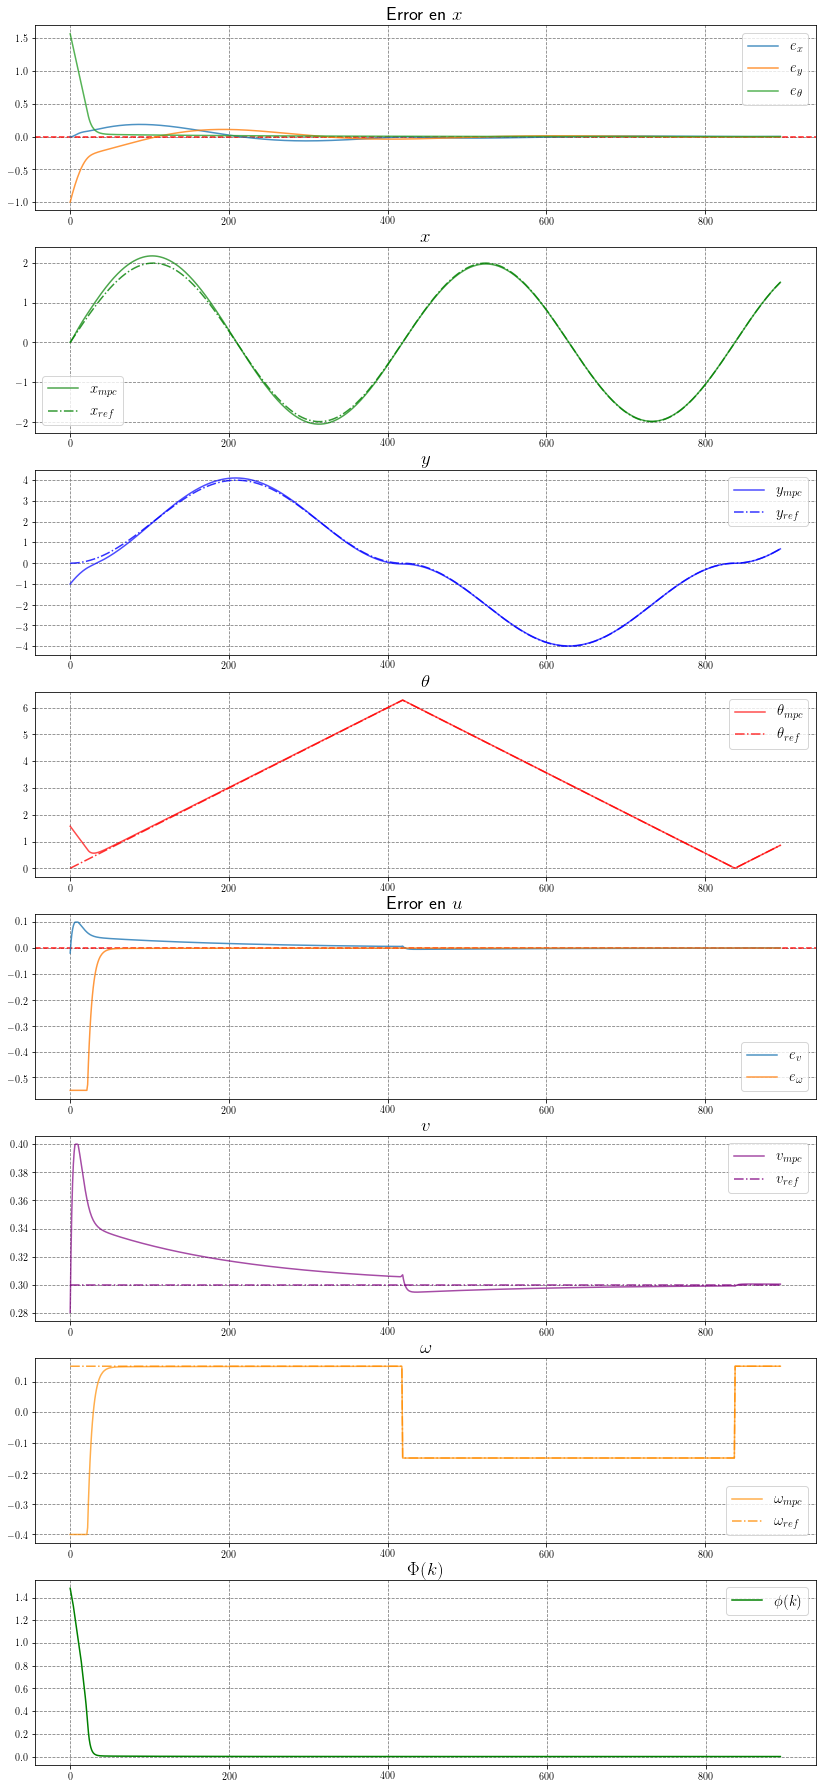

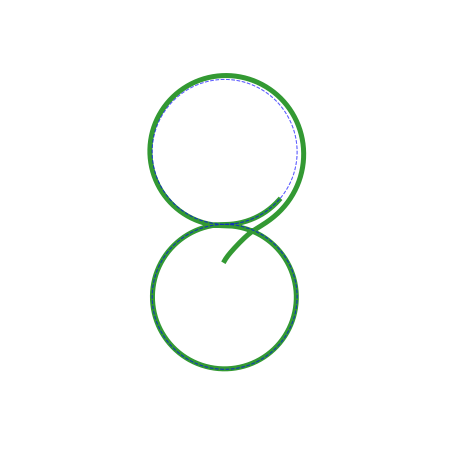

In [18]:
N = 5

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_5_sinPer.mp4");

In [19]:
HTML(anim.to_html5_video())

Horizonte = 10
Tiempo promedio para problema de optimización = 8.570746089635271e-06 segundos
Tiempo promedio para iteración = 1.724328887596559e-05 segundos


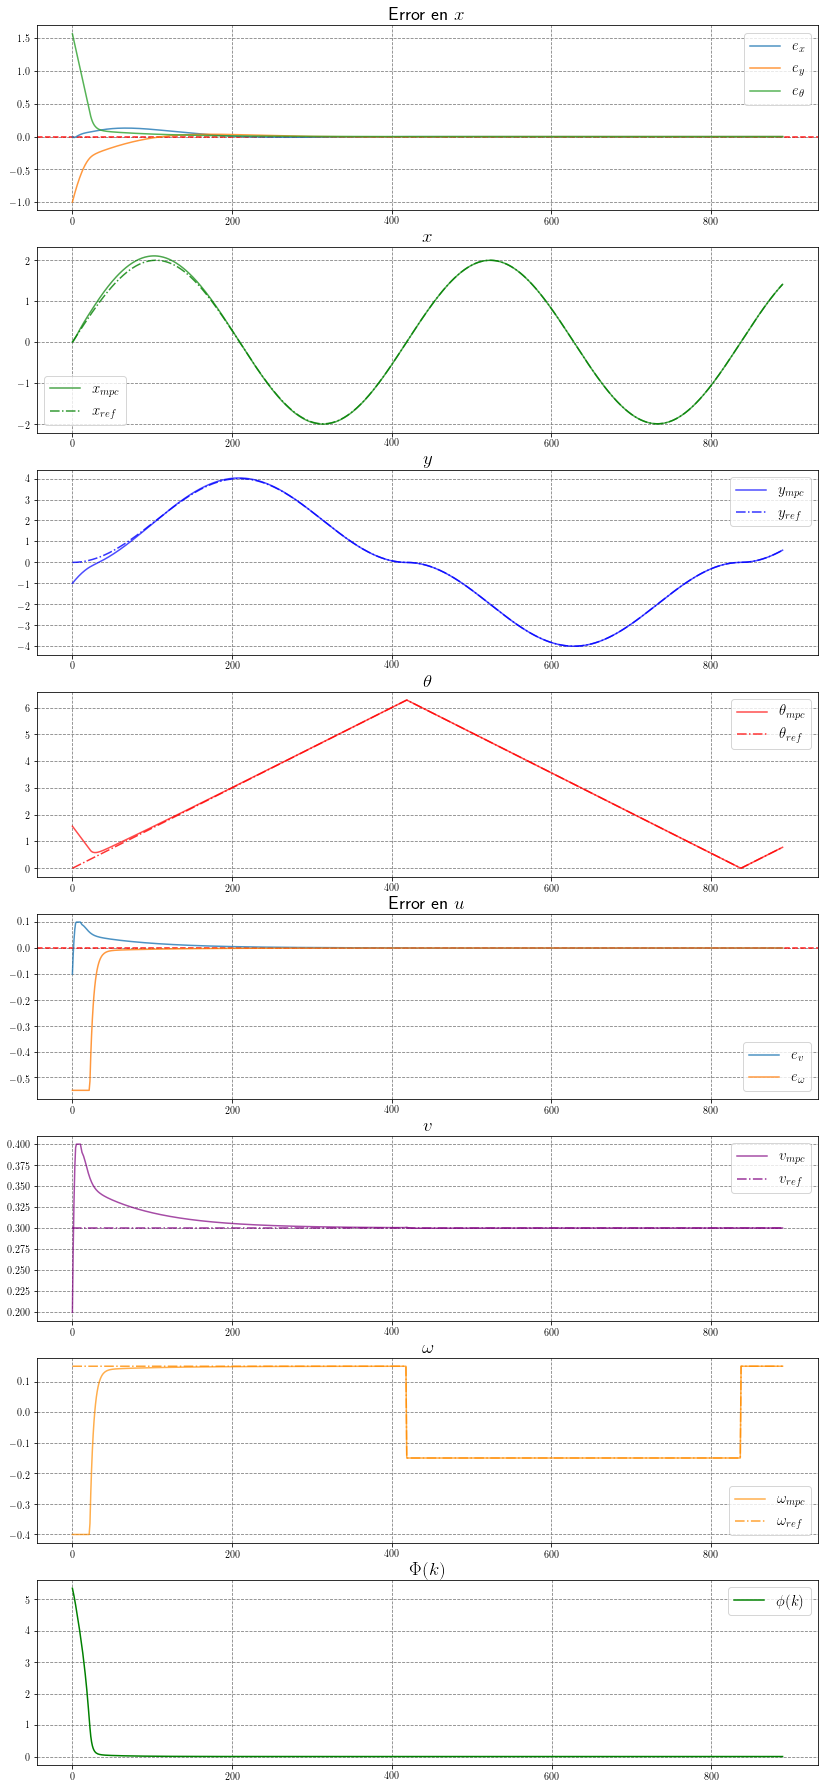

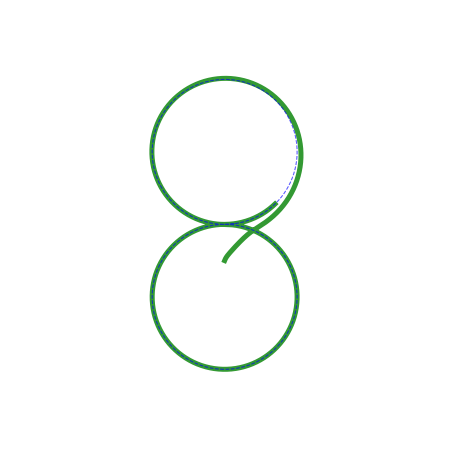

In [20]:
N = 10

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_10_sinPer.mp4");

In [21]:
HTML(anim.to_html5_video())

Horizonte = 15
Tiempo promedio para problema de optimización = 2.5840532981743246e-05 segundos
Tiempo promedio para iteración = 5.222228960802326e-05 segundos


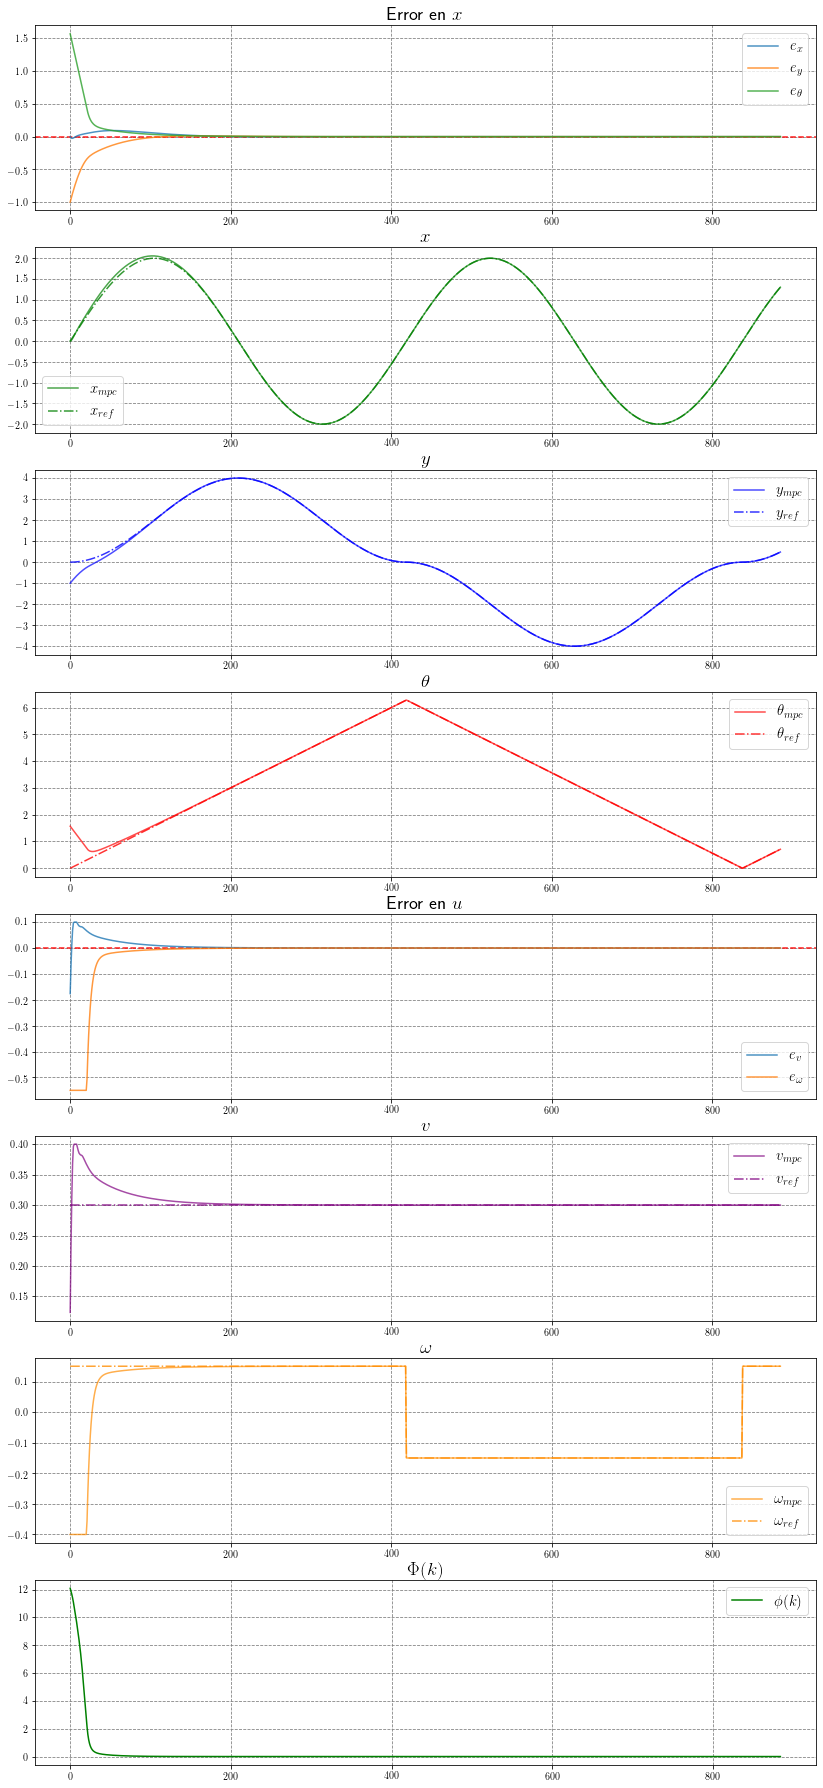

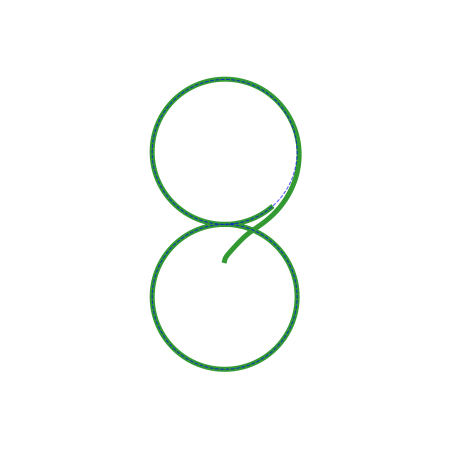

In [22]:
N = 15

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_15_sinPer.mp4");

In [23]:
HTML(anim.to_html5_video())

N = 20

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_20_sinPer.mp4");

HTML(anim.to_html5_video())

N = 30

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, sin_perturbacion, plot=False, animationFile="N_30_sinPer.mp4");

HTML(anim.to_html5_video())

### Simulaciones con perturbación ruidosa en cada instante

N = 1

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_1_ruido.mp4");

HTML(anim.to_html5_video())

N = 3

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_3_ruido.mp4");

HTML(anim.to_html5_video())

Horizonte = 5
Tiempo promedio para problema de optimización = 1.5466572852108065e-06 segundos
Tiempo promedio para iteración = 3.3530443074316952e-06 segundos


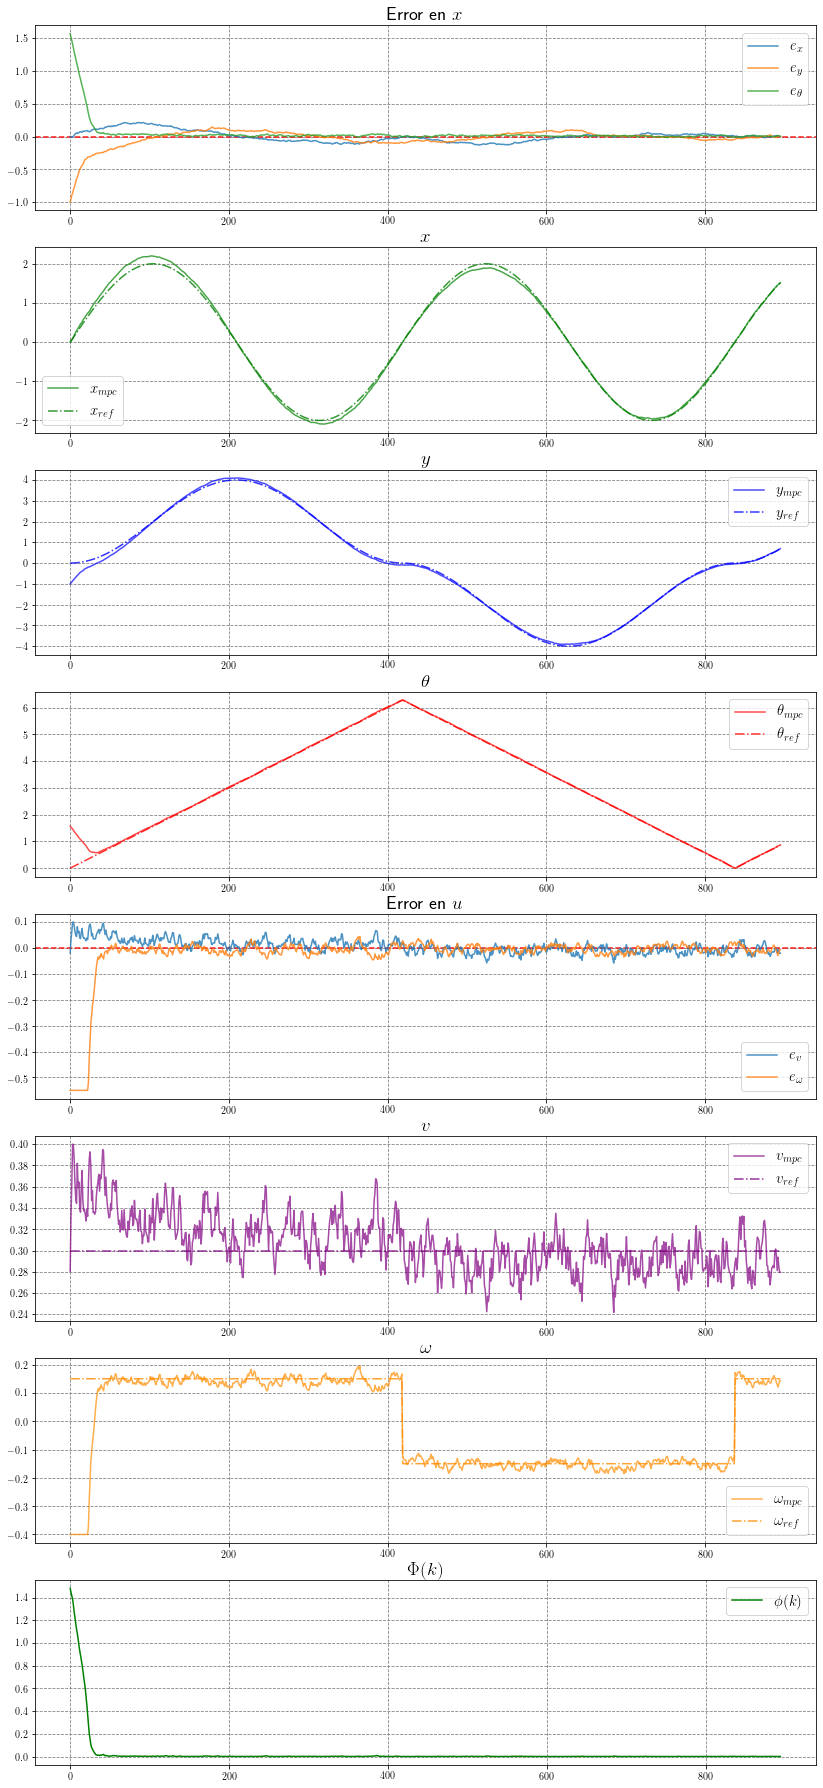

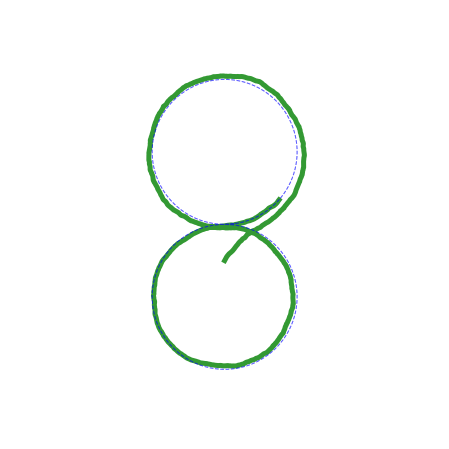

In [24]:
N = 5

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_5_ruido.mp4");

In [25]:
HTML(anim.to_html5_video())

Horizonte = 10
Tiempo promedio para problema de optimización = 9.07865802893478e-06 segundos
Tiempo promedio para iteración = 1.792398731360275e-05 segundos


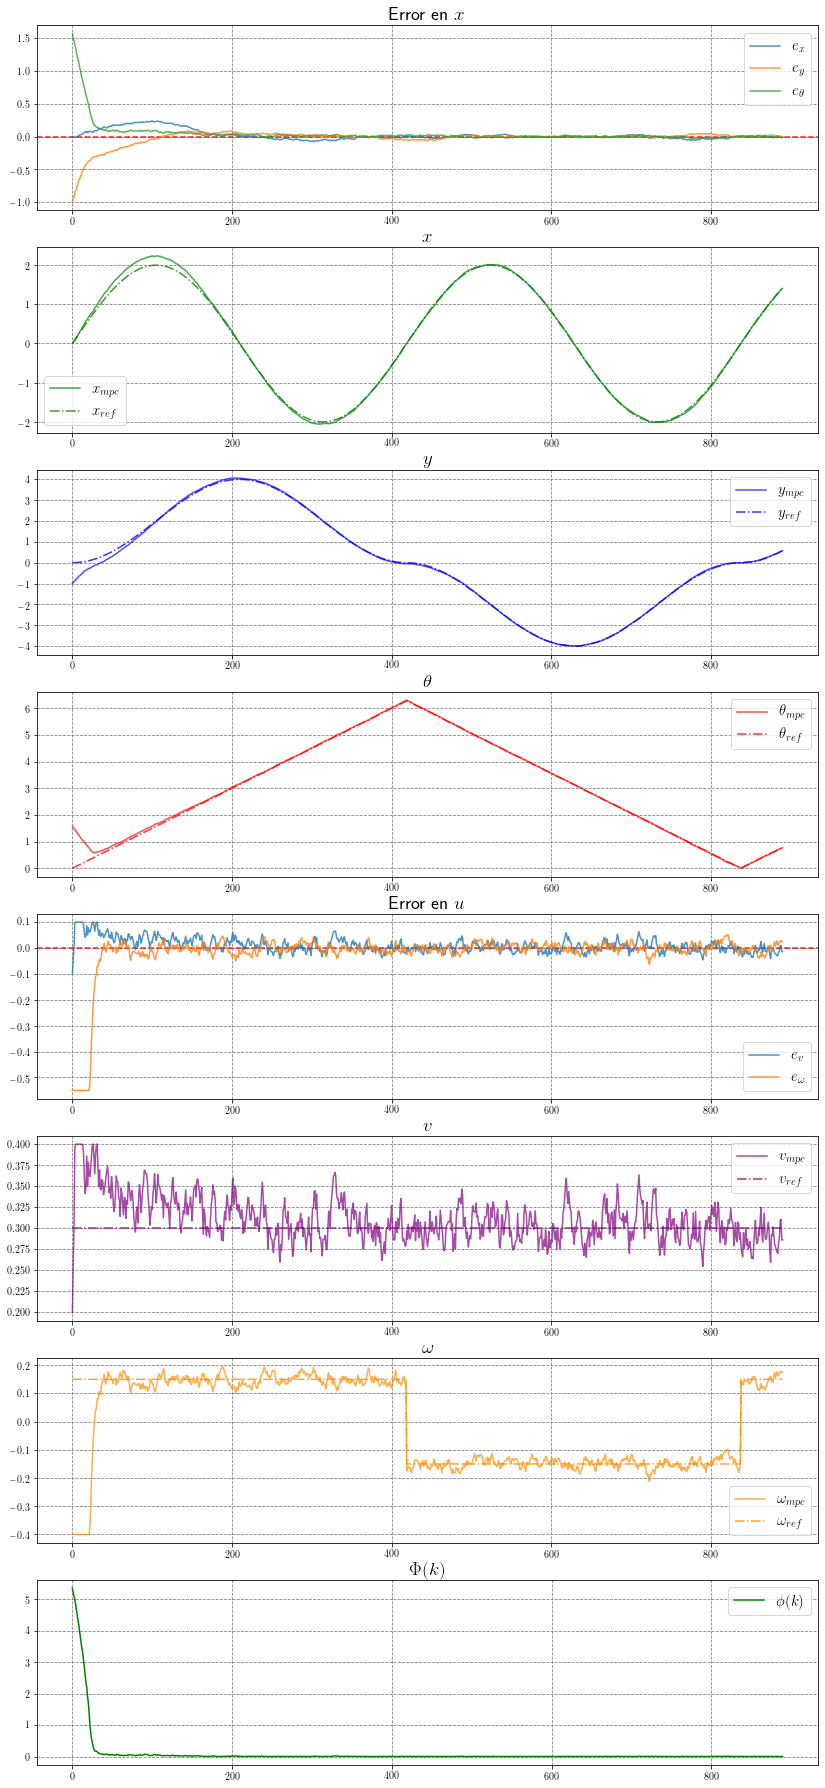

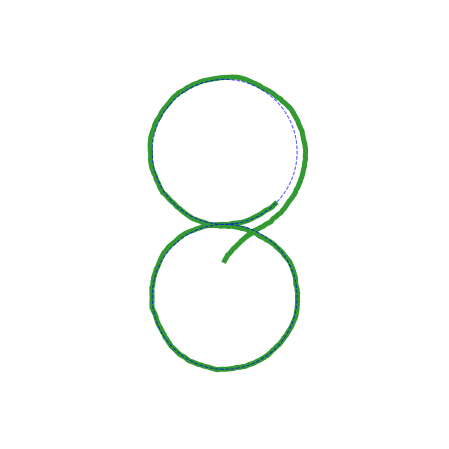

In [26]:
N = 10

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_10_ruido.mp4");

In [27]:
HTML(anim.to_html5_video())

Horizonte = 15
Tiempo promedio para problema de optimización = 3.5709176359877074e-05 segundos
Tiempo promedio para iteración = 7.827133782165872e-05 segundos


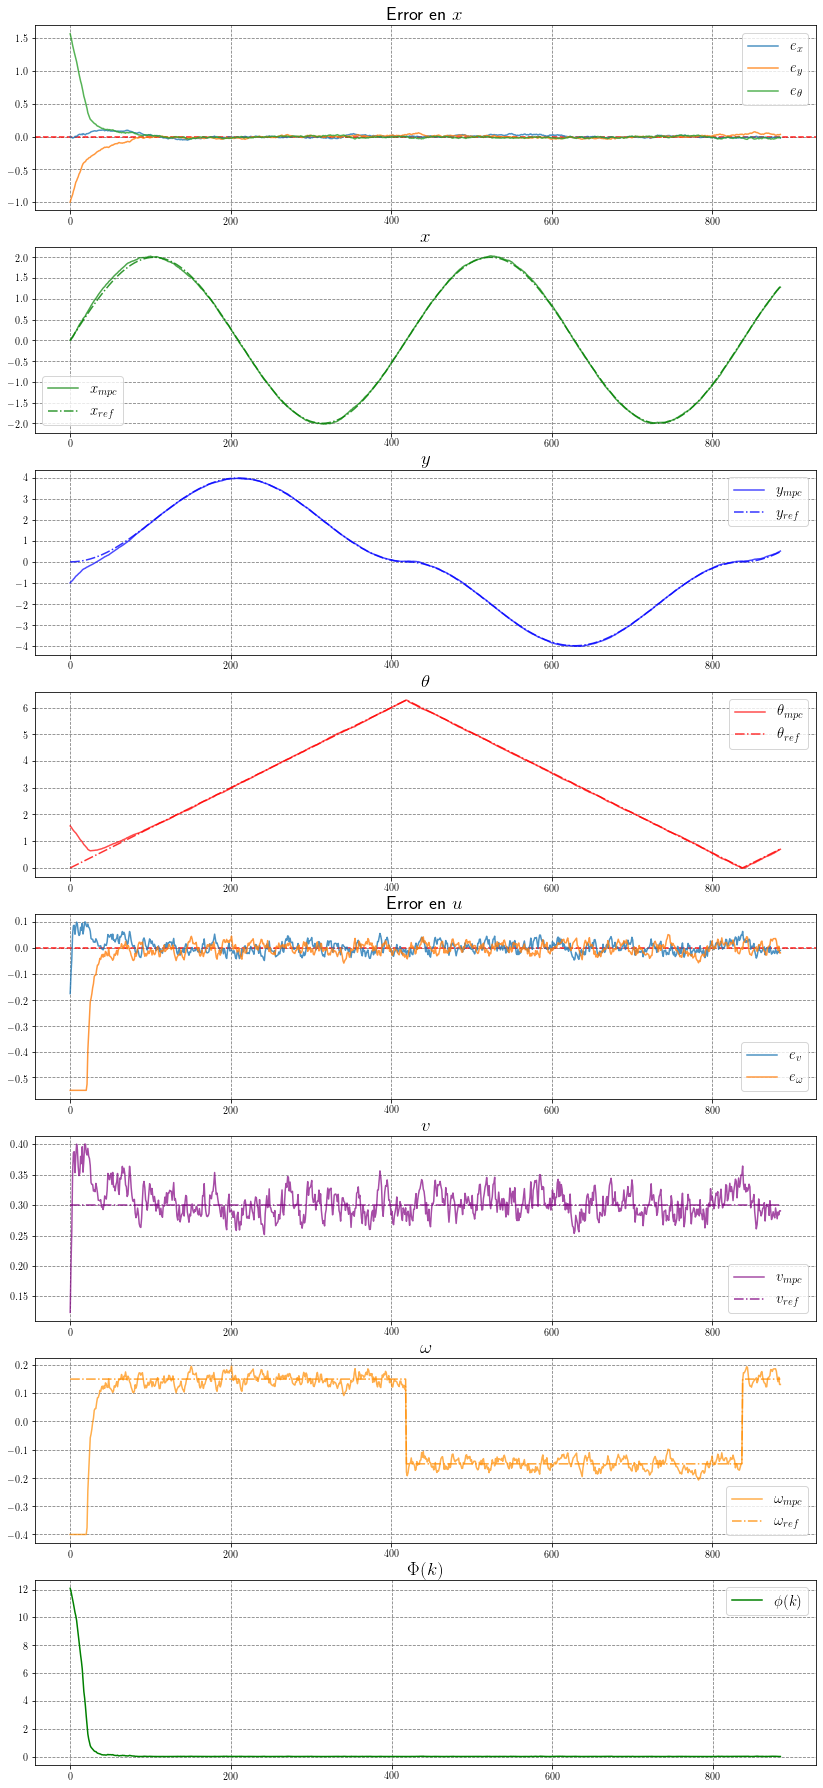

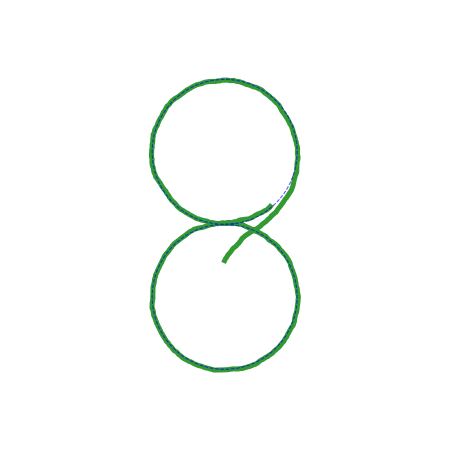

In [28]:
N = 15

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_15_ruido.mp4");

In [29]:
HTML(anim.to_html5_video())

N = 20

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_20_ruido.mp4");

HTML(anim.to_html5_video())

N = 30

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, ruido_cte, prop=0.05, plot=False, animationFile="N_30_ruido.mp4");

HTML(anim.to_html5_video())

### Simulaciones con perturbación constante tras un periodo de tiempo

N = 1

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_1_perturbCte.mp4");

HTML(anim.to_html5_video())

N = 3

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_3_perturbCte.mp4");

HTML(anim.to_html5_video())

Horizonte = 5
Tiempo promedio para problema de optimización = 1.7264701800639403e-06 segundos
Tiempo promedio para iteración = 3.383679096925192e-06 segundos


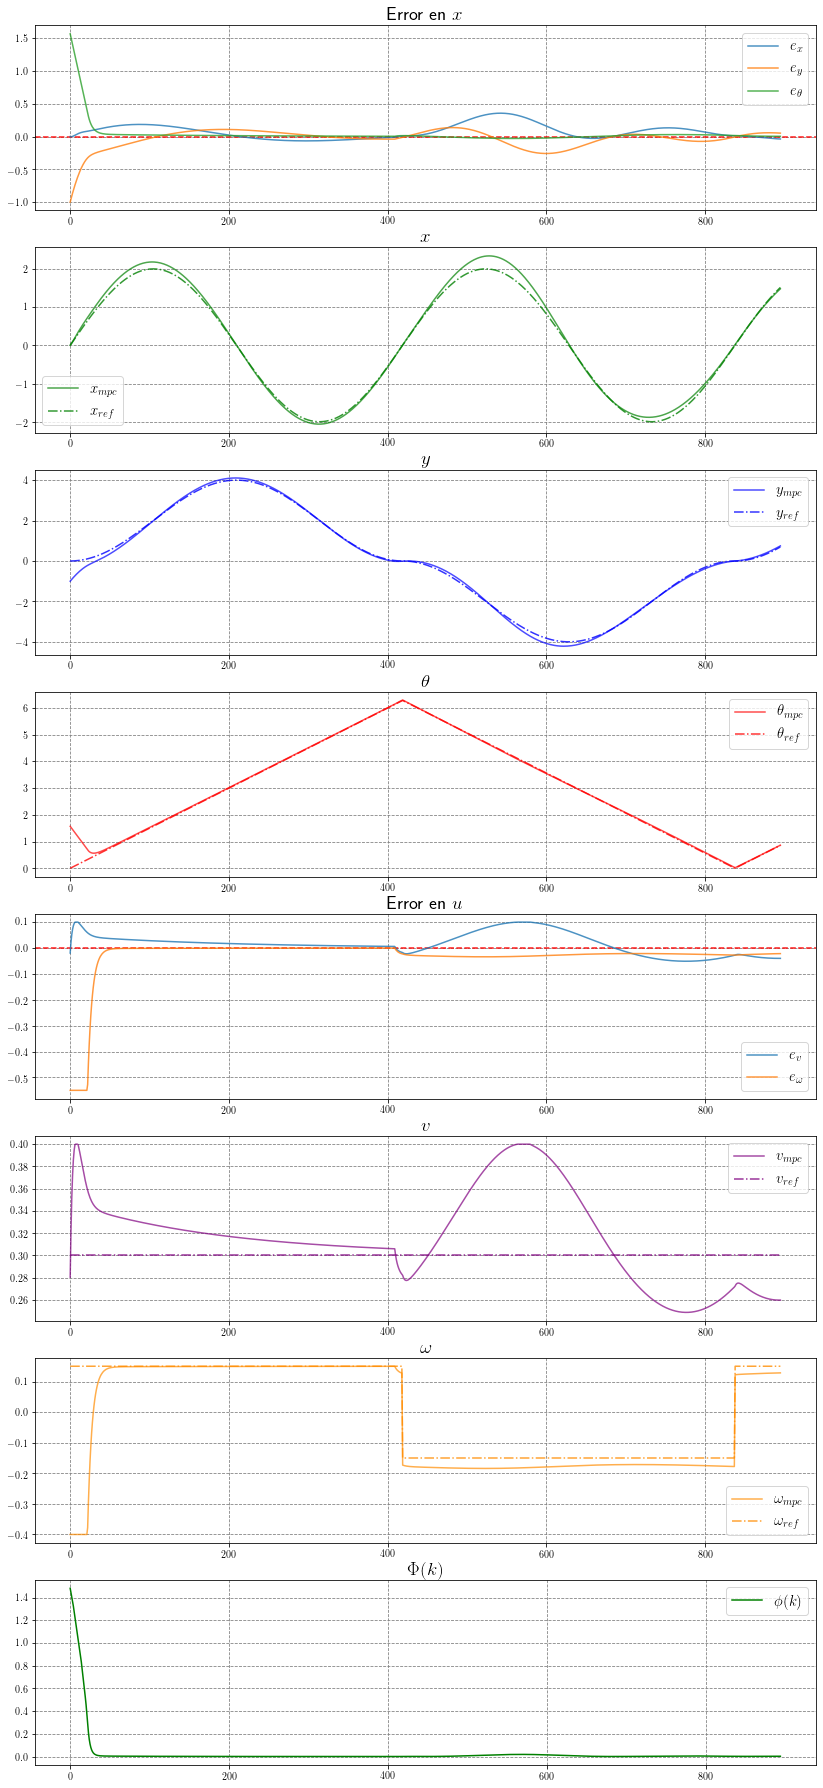

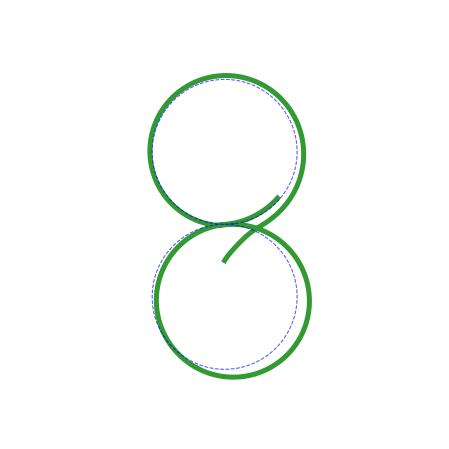

In [32]:
N = 5

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_5_perturbCte.mp4");

In [33]:
HTML(anim.to_html5_video())

Horizonte = 10
Tiempo promedio para problema de optimización = 8.85899147290862e-06 segundos
Tiempo promedio para iteración = 1.778602600097656e-05 segundos


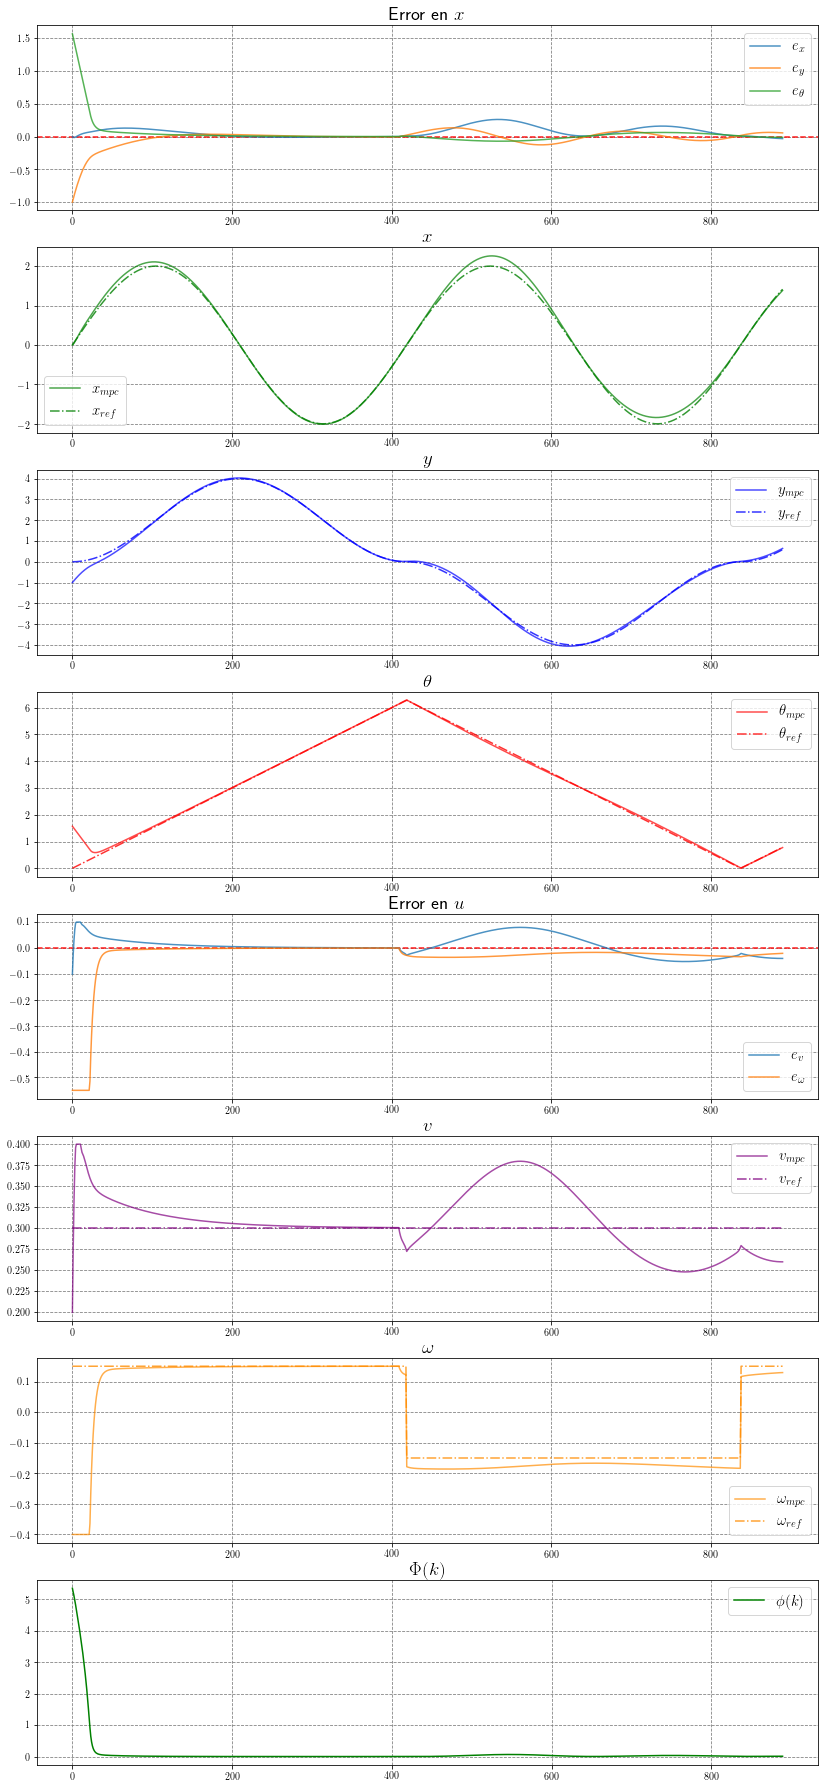

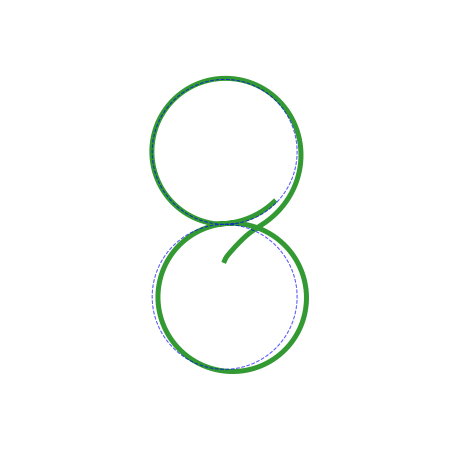

In [34]:
N = 10

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_10_perturbCte.mp4");

In [35]:
HTML(anim.to_html5_video())

Horizonte = 15
Tiempo promedio para problema de optimización = 2.612340248237222e-05 segundos
Tiempo promedio para iteración = 5.275273727158369e-05 segundos


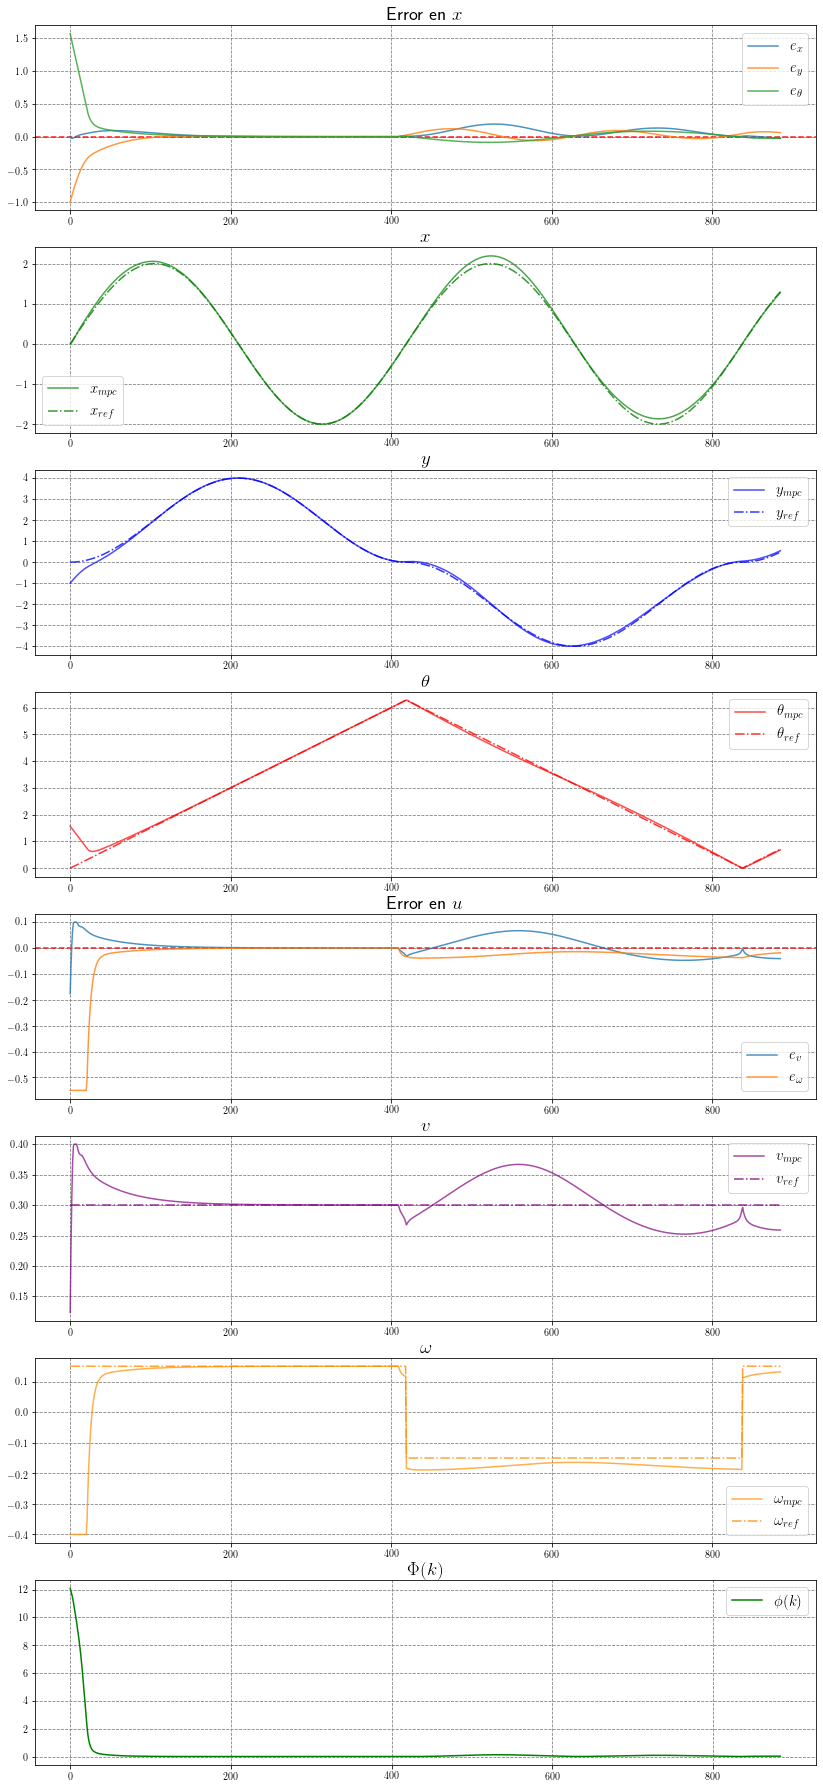

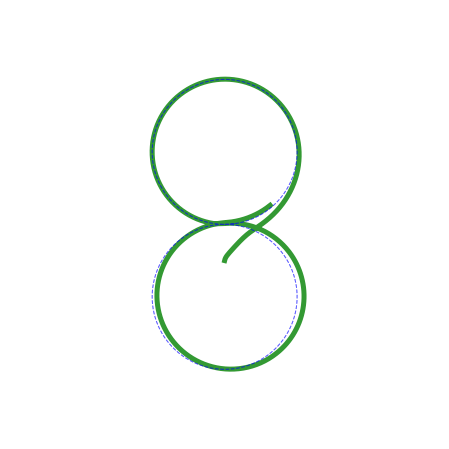

In [36]:
N = 15

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_15_perturbCte.mp4");

In [37]:
HTML(anim.to_html5_video())

N = 20

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_20_perturbCte.mp4");

HTML(anim.to_html5_video())

N = 30

Q_bar = W_bar(diagQ)
R_bar = W_bar(diagR)

_, _, _, _, _, anim = MPC(x_0, x_r, u_r, N, nt, T, perturbacion_cte, plot=False, animationFile="N_30_perturbCte.mp4");

HTML(anim.to_html5_video())